In [37]:
import pandas as pd
import numpy as np
import pymysql
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')
config.sections()

['SOS_DB', 'docdx_db_production']

In [3]:
sos_db_section = config['SOS_DB']
host = sos_db_section['host']
user = sos_db_section['user']
password = sos_db_section['password']
db=sos_db_section['db']
port = int(sos_db_section.get('port', 3306))
db = pymysql.connect(host=host, user=user, password=password, db=db, port=port)

import_db_section = config['docdx_db_production']
host = import_db_section['host']
user = import_db_section['user']
password = import_db_section['password']
db_dx=import_db_section['db']
port = int(sos_db_section.get('port',5432))

conn_str = "host={} dbname={} user={} password={}".format(host, db_dx, user, password)
db_docdx = psycopg2.connect(conn_str)

In [97]:
plt.style.use('fivethirtyeight')

#width, height = plt.figaspect(4)
#fig = plt.figure(figsize=(width,height), dpi=400)
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Sans'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

Since January 2019, how many users logged back into docdx or 

old app a second time after their first login by month?

By month second clicked

any distribution retention / churn

In [20]:
query = """SELECT m.id session_id, m.user_id, spe.name spe, sub.name subspe, m.used_at::date
FROM private.magic_link m
JOIN public."user_profile" up
ON m.user_id = up.user_id
JOIN specialty spe
ON spe.id = up.specialty_id
JOIN subspecialty sub
ON sub.id = up.subspecialty_id 
where m.used_at is not null """
table = pd.read_sql(query, db_docdx)

In [21]:
table = table.sort_values(['user_id','used_at']).reset_index(drop = True)

In [22]:
df = table

In [23]:
df['period'] = df.used_at.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,session_id,user_id,spe,subspe,used_at,period
0,15245034,472046,Internal Medicine,Internal Medicine,2019-03-05,2019-03
1,3037934,472064,Dermatology,Dermatology,2018-08-16,2018-08
2,6268528,472064,Dermatology,Dermatology,2018-10-15,2018-10
3,4940845,472080,Gastroenterology,Gastroenterology,2018-09-19,2018-09
4,7976810,472090,Internal Medicine,Internal Medicine,2018-11-26,2018-11


In [24]:
# Set the DataFrame index (row labels) using one or more existing columns.
df.set_index('user_id', inplace=True)

# Creare Cohort Group base on first session date of the user
df['CohortGroup'] = df.groupby(level=0)['used_at'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

In [25]:
df.head()

,user_id,session_id,spe,subspe,used_at,period,CohortGroup
0,472046,15245034,Internal Medicine,Internal Medicine,2019-03-05,2019-03,2019-03
1,472064,3037934,Dermatology,Dermatology,2018-08-16,2018-08,2018-08
2,472064,6268528,Dermatology,Dermatology,2018-10-15,2018-10,2018-08
3,472080,4940845,Gastroenterology,Gastroenterology,2018-09-19,2018-09,2018-09
4,472090,7976810,Internal Medicine,Internal Medicine,2018-11-26,2018-11,2018-11


In [26]:
user_tot = df.groupby(['period', 'user_id']).sum()
user_tot.reset_index(inplace=True)
user_tot.head()

,period,user_id,session_id
0,2018-08,472064,3037934
1,2018-08,472148,3764184
2,2018-08,472154,3766637
3,2018-08,472300,3278575
4,2018-08,472472,3721350


In [29]:
grouped = df.groupby(['CohortGroup', 'period'])
grouped_1 = grouped
# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'session_id': pd.Series.nunique})

# make the column names more meaningful
cohorts.rename(columns={'user_id': 'TotalUsers',
                        'session_date': 'TotalSession'}, inplace=True)
cohorts.head()

TotalUsers  session_id
CohortGroup period                         
2018-08     2018-08        1868        2568
            2018-09         897        1819
            2018-10         800        2012
            2018-11         736        1410
            2018-12         464         916

In [30]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [69]:
cohorts.head()

period  TotalUsers  session_id
CohortGroup CohortPeriod                                 
2018-08     1             2018-08        1868        2568
            2             2018-09         897        1819
            3             2018-10         800        2012
            4             2018-11         736        1410
            5             2018-12         464         916

In [55]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()

In [56]:
cohort_group_size

CohortGroup
2018-08    1868
2018-09    2814
2018-10    2177
2018-11    2622
2018-12    1531
2019-01    1137
2019-02     874
2019-03    1278
2019-04     695
Name: TotalUsers, dtype: int64

In [57]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention_abs = cohorts['TotalUsers'].unstack(0)
user_retention.head(10)
user_retention


CohortGroup,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04
CohortPeriod,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.480193,0.358564,0.299495,0.278795,0.180927,0.283201,0.302059,0.157277,NaN
3,0.428266,0.375977,0.163068,0.135393,0.174396,0.262973,0.120137,NaN,NaN
4,0.394004,0.280384,0.159394,0.117086,0.284128,0.163588,NaN,NaN,NaN
5,0.248394,0.171642,0.127239,0.152555,0.197257,NaN,NaN,NaN,NaN
6,0.203426,0.159204,0.146991,0.091533,NaN,NaN,NaN,NaN,NaN
7,0.178266,0.190476,0.088195,NaN,NaN,NaN,NaN,NaN,NaN
8,0.195396,0.123312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.140792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
width, height = plt.figaspect(0.6)
width
height

4.0

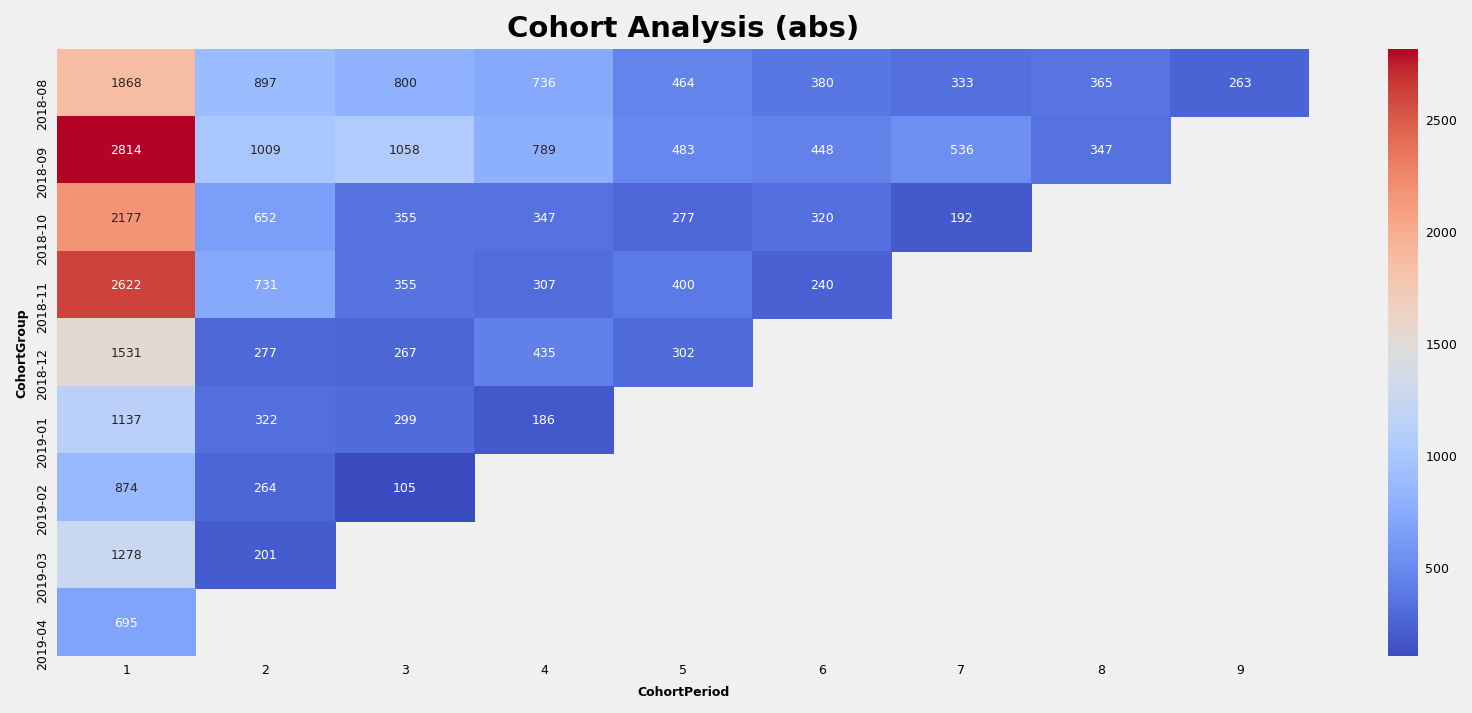

In [102]:
#width, height = plt.figaspect(0.6)
fig = plt.figure(figsize=(12,5), dpi=150)
#plt.text(-1.6, 19.0, s = 'Cohort Analysis (%)', fontsize = 14,  fontweight='bold')#", fontname='Ubuntu', fontsize=14, fontweight='semibold')
#plt.text(-1.6, 16.7, s = 'Cohort analysis is a subset of behavioral analytics that takes the data from a \ngiven dataset and rather than looking at all users as one unit, it breaks them \ninto related groups for analysis.', fontsize = 9,  fontweight='medium')
plt.title("Cohort Analysis (abs)", fontname='Ubuntu', fontsize=14, fontweight='bold')
#plt.yticks(rotation = True)
sns.heatmap(user_retention_abs.T, mask=user_retention.T.isnull(), annot=True, fmt='g', cmap='coolwarm')

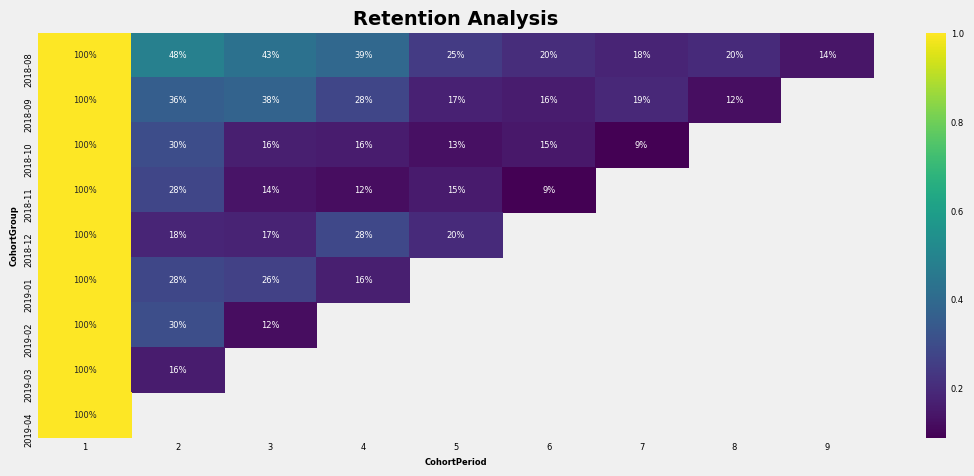

In [103]:
#width, height = plt.figaspect(.6)
fig = plt.figure(figsize=(12,5), dpi=100)
#plt.text(-1.6, 19.0, s = 'Cohort Analysis (%)', fontsize = 14,  fontweight='bold')#", fontname='Ubuntu', fontsize=14, fontweight='semibold')
#plt.text(-1.6, 16.7, s = 'Cohort analysis is a subset of behavioral analytics that takes the data from a \ngiven dataset and rather than looking at all users as one unit, it breaks them \ninto related groups for analysis.', fontsize = 9,  fontweight='medium')

plt.title("Retention Analysis", fontname='Ubuntu', fontsize=14, fontweight='bold')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='0.00%', cmap='viridis')

<Figure size 1000x500 with 0 Axes>

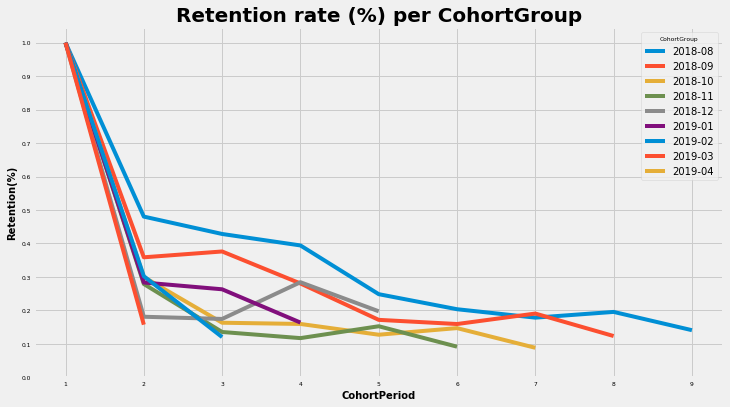

In [101]:
#width, height = plt.figaspect(.6)
fig = plt.figure(figsize=(10,5), dpi=100)

ax = user_retention[['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
       '2019-02', '2019-03', '2019-04']].plot(figsize=(11,6))
plt.title("Retention rate (%) per CohortGroup", fontname='Ubuntu', fontsize=20, fontweight='bold')

plt.xticks(np.arange(1, 9.1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("CohortPeriod", fontsize=10)
ax.set_ylabel("Retention(%)", fontsize=10)
plt.show()

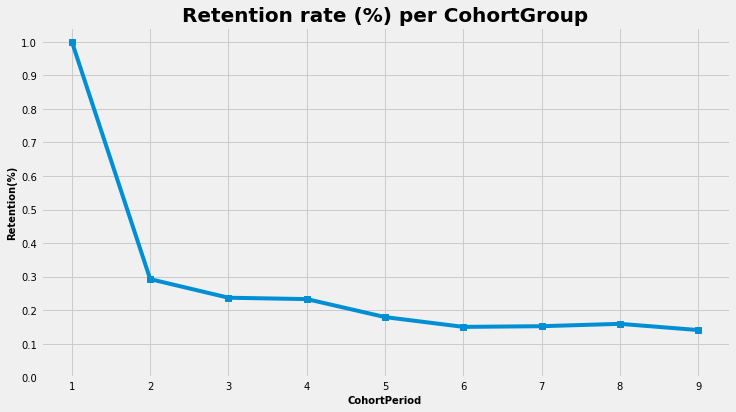

In [64]:
ax = user_retention.T.mean().plot(figsize=(11,6), marker='s')
plt.title("Retention rate (%) per CohortGroup", fontname='Ubuntu', fontsize=20, fontweight='bold')

plt.xticks(np.arange(1, 9.1, 1), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
ax.set_xlabel("CohortPeriod", fontsize=10)
ax.set_ylabel("Retention(%)", fontsize=10)
plt.show()

In [104]:
df.spe.unique()

array(['Internal Medicine', 'Dermatology', 'Gastroenterology',
       'Family Practice', 'Pulmonology', 'Oncology / Hematology',
       'Cardiology', 'Anesthesia / Pain', 'Neurology',
       'Endocrinology / Diabetes', 'Rheumatology', 'UNSPECIFIED / OTHER',
       'Psychiatry', 'Ophthalmology / Optometrists',
       'Obstetrics / Gynecology', 'Allergy / Immunology', 'Urology',
       'Pediatrics', 'Surgeons', 'Hospitalist', 'Radiology', 'OTO / ENT',
       'Nurse Practitioners', 'Infectious Disease / HIV'], dtype=object)

In [114]:
def finalize(table, spe):
    # Set the DataFrame index (row labels) using one or more existing columns.
    
    df = table[table.spe == spe]
    df.set_index('user_id', inplace=True)

    # Creare Cohort Group base on first session date of the user
    df['CohortGroup'] = df.groupby(level=0)['used_at'].min().apply(lambda x: x.strftime('%Y-%m'))
    df.reset_index(inplace=True)
    grouped = df.groupby(['CohortGroup', 'period'])
    grouped_1 = grouped
    # count the unique users, orders, and total revenue per Group + Period
    cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'session_id': pd.Series.nunique})

    # make the column names more meaningful
    cohorts.rename(columns={'user_id': 'TotalUsers',
                        'session_date': 'TotalSession'}, inplace=True)
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    
    # reindex the DataFrame
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

    # create a Series holding the total size of each CohortGroup
    cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
    
    user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    user_retention_abs = cohorts['TotalUsers'].unstack(0)
    
    
    #width, height = plt.figaspect(0.6)
    fig = plt.figure(figsize=(12,5), dpi=150)
    plt.title("Cohort Analysis (abs) - " + str(spe), fontname='Ubuntu', fontsize=14, fontweight='bold')
    sns.heatmap(user_retention_abs.T, mask=user_retention.T.isnull(), annot=True, fmt='g', cmap='coolwarm')
    plt.show()
    
    fig = plt.figure(figsize=(12,5), dpi=150)
    plt.title("Retention Analysis - " + str(spe), fontname='Ubuntu', fontsize=14, fontweight='bold')
    sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='0.00%', cmap='viridis')
    plt.show()
    
    #width, height = plt.figaspect(.6)
    fig = plt.figure(figsize=(12,5), dpi=150)

    ax = user_retention[['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
       '2019-02', '2019-03', '2019-04']].plot(figsize=(11,6))
    plt.title("Retention rate (%) per CohortGroup in " + str(spe), fontname='Ubuntu', fontsize=20, fontweight='bold')
    
    
    plt.xticks(np.arange(1, 9.1, 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel("CohortPeriod", fontsize=10)
    ax.set_ylabel("Retention(%)", fontsize=10)
    plt.show()

In [116]:
df.spe.unique()

array(['Internal Medicine', 'Dermatology', 'Gastroenterology',
       'Family Practice', 'Pulmonology', 'Oncology / Hematology',
       'Cardiology', 'Anesthesia / Pain', 'Neurology',
       'Endocrinology / Diabetes', 'Rheumatology', 'UNSPECIFIED / OTHER',
       'Psychiatry', 'Ophthalmology / Optometrists',
       'Obstetrics / Gynecology', 'Allergy / Immunology', 'Urology',
       'Pediatrics', 'Surgeons', 'Hospitalist', 'Radiology', 'OTO / ENT',
       'Nurse Practitioners', 'Infectious Disease / HIV'], dtype=object)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


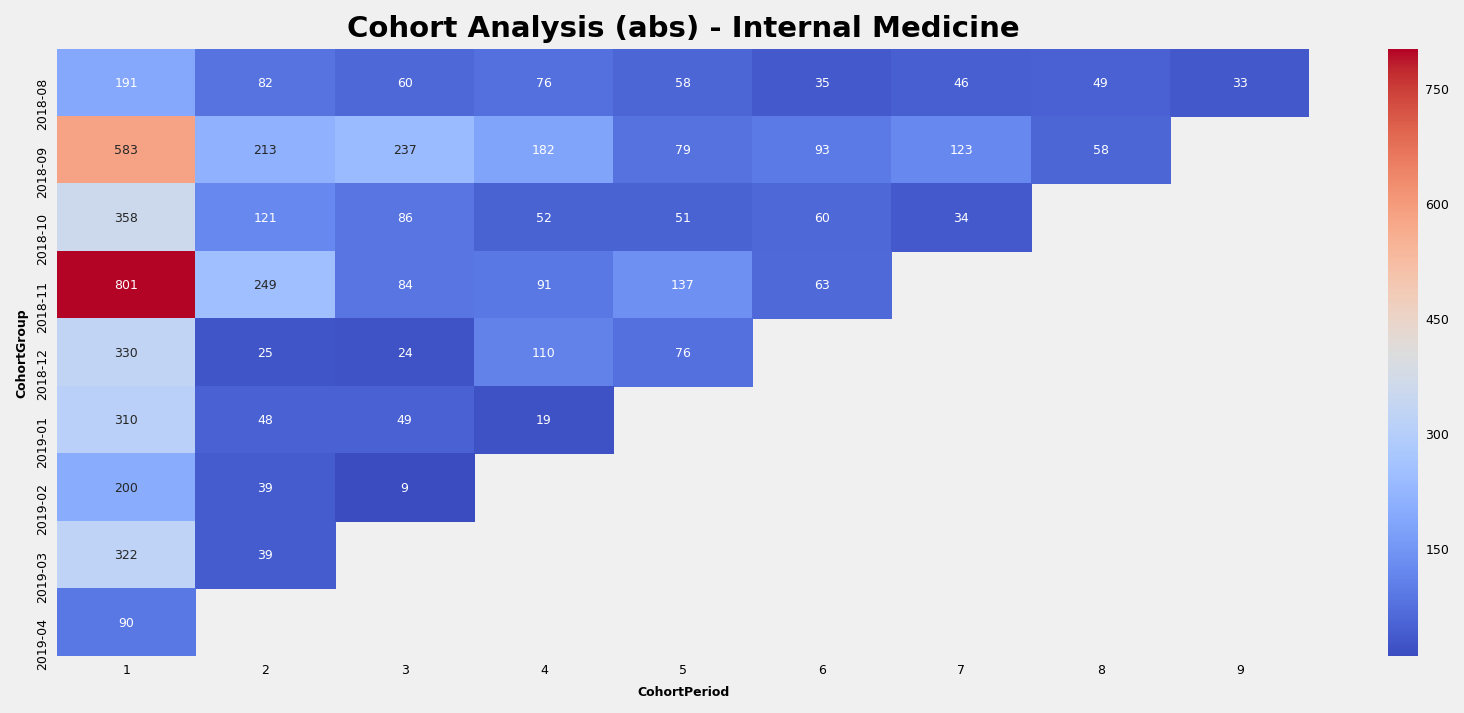

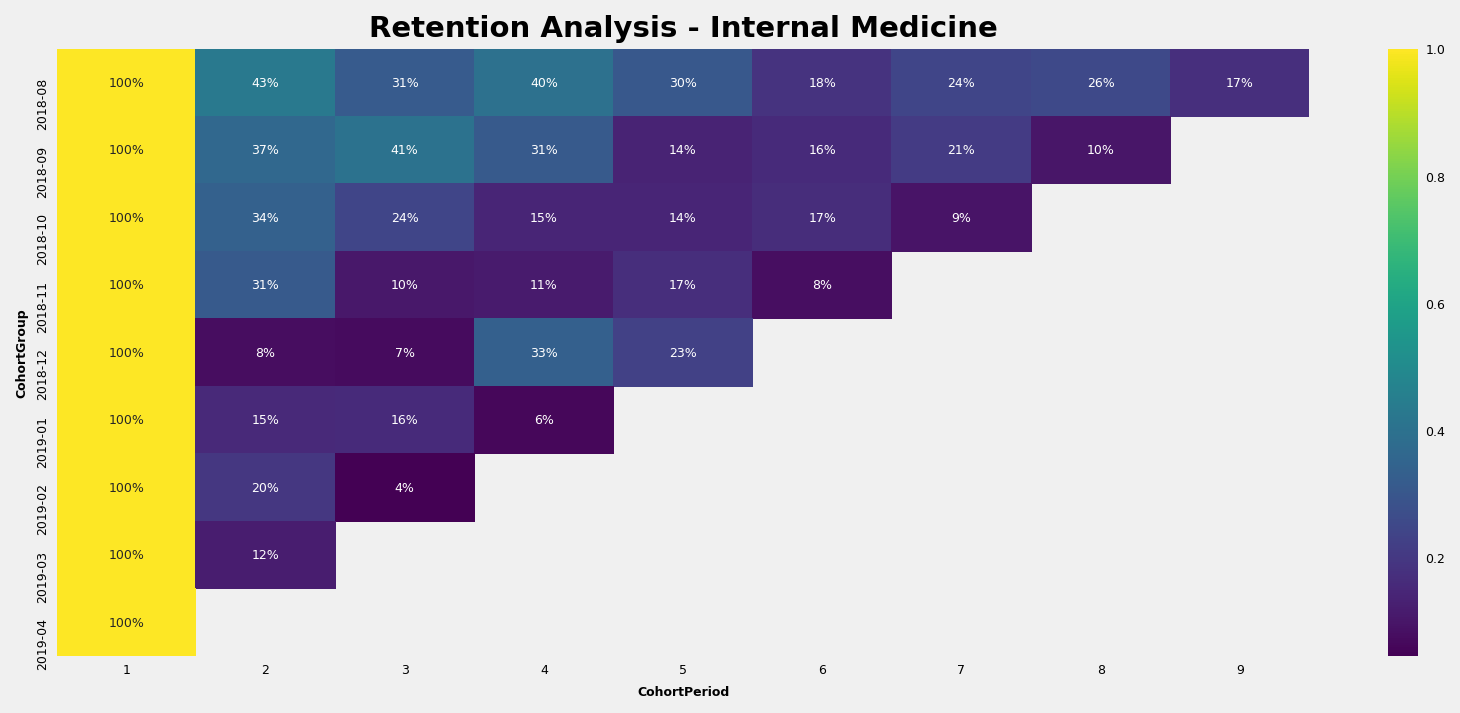

<Figure size 1800x750 with 0 Axes>

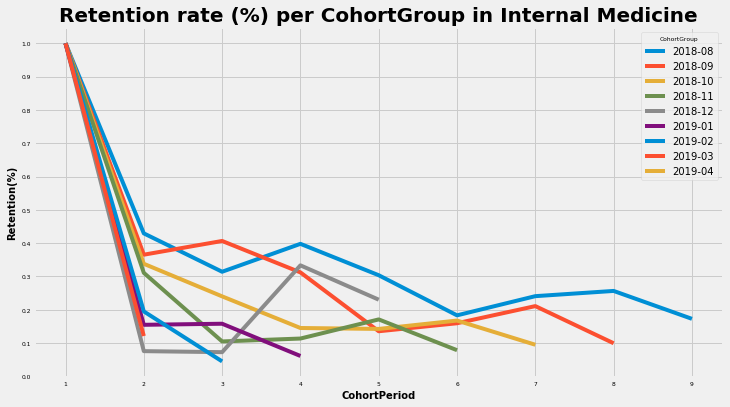

In [115]:
finalize(df, 'Internal Medicine')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


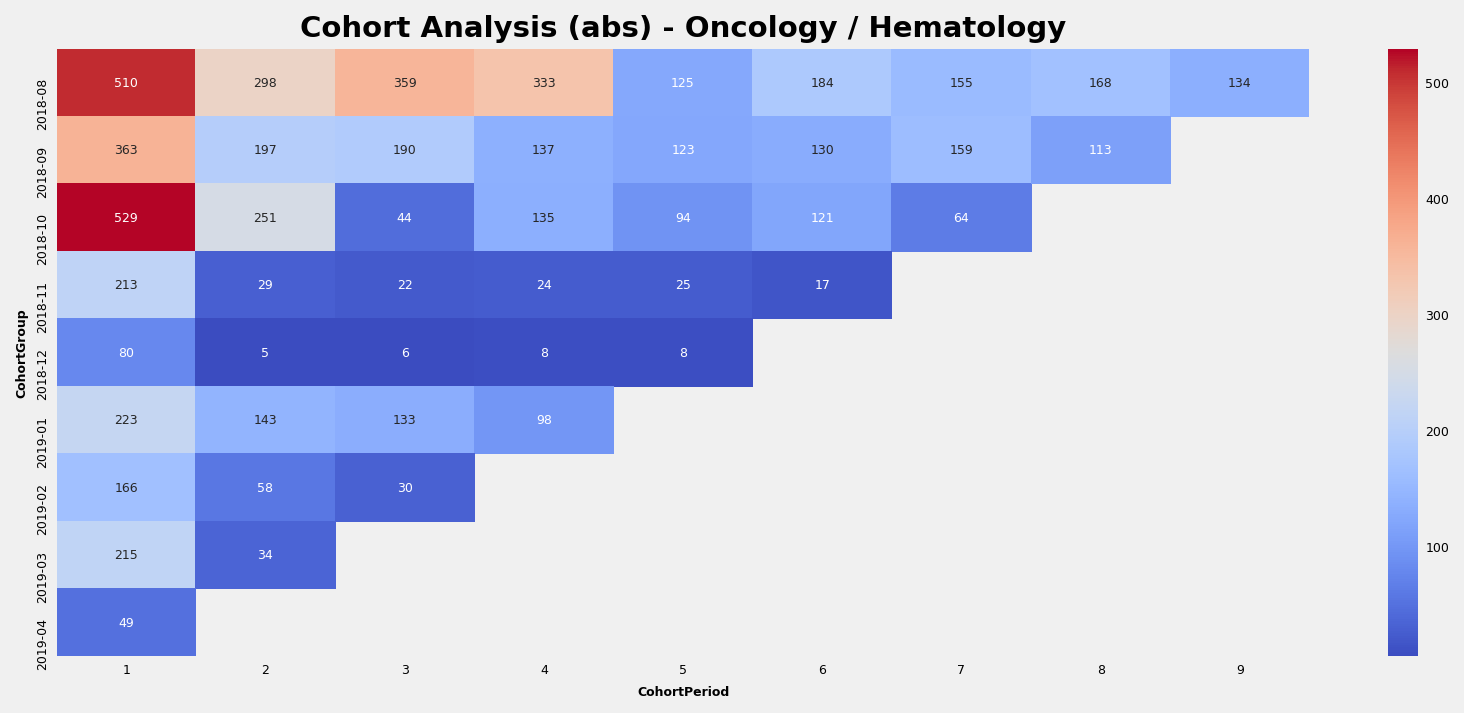

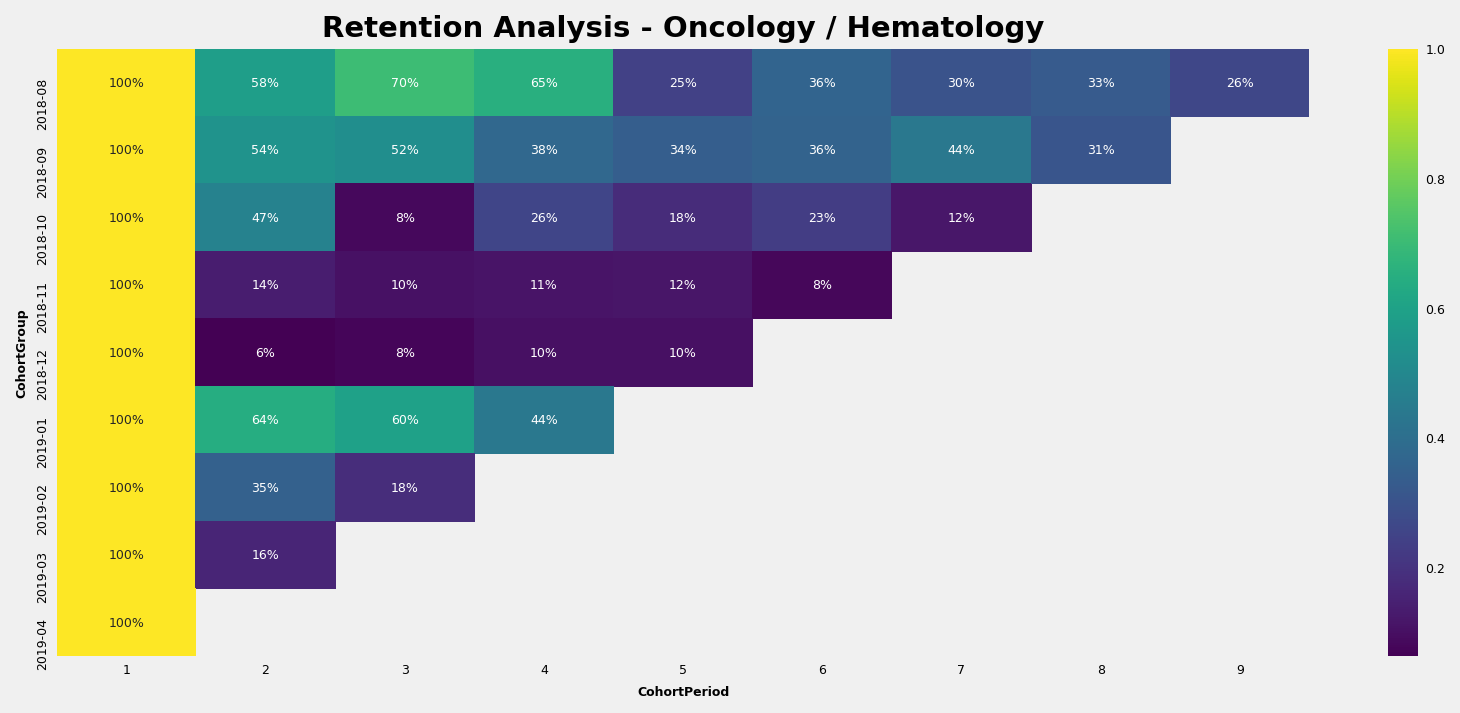

<Figure size 1800x750 with 0 Axes>

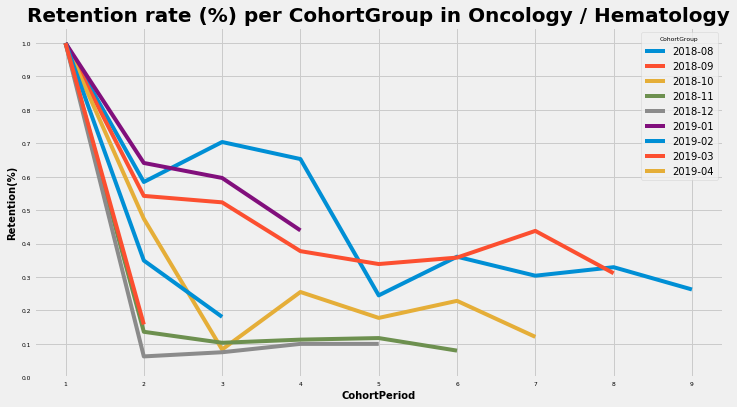

In [117]:
finalize(df, 'Oncology / Hematology')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


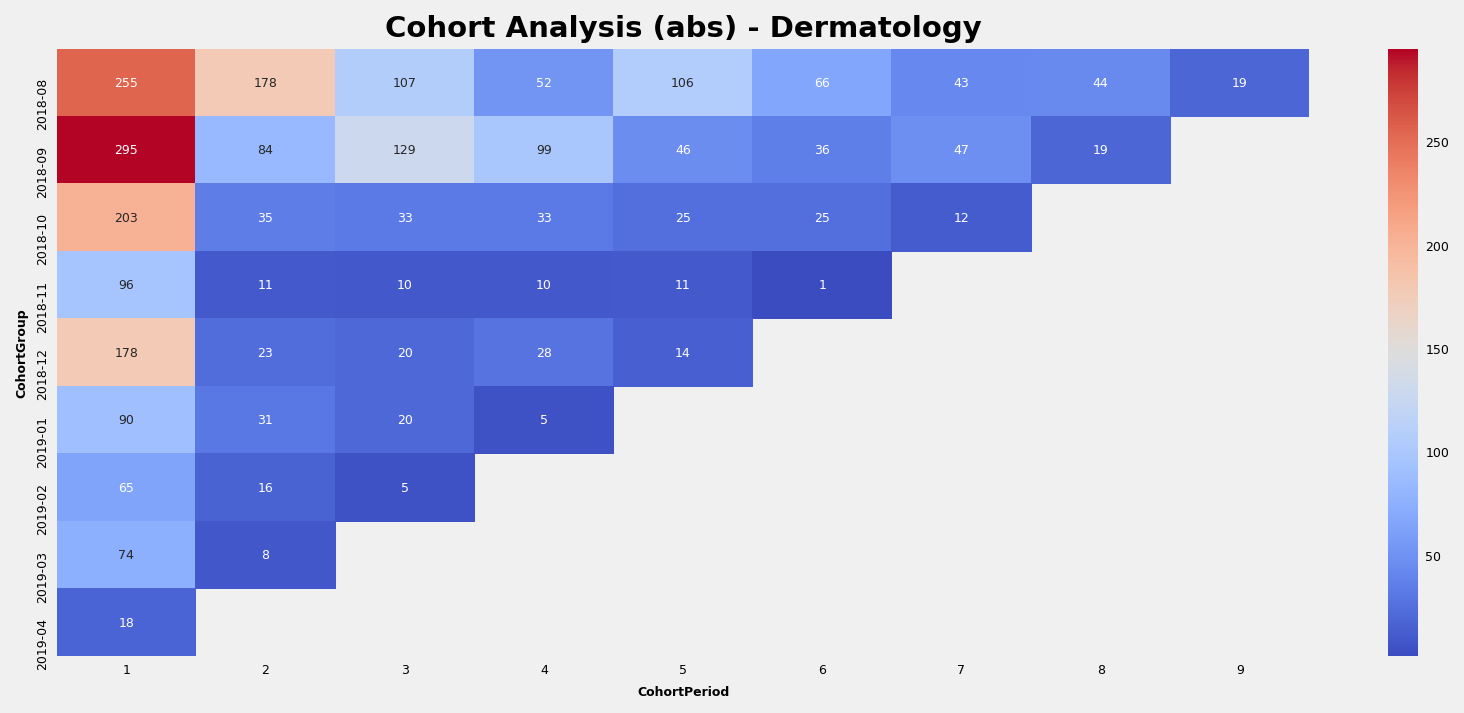

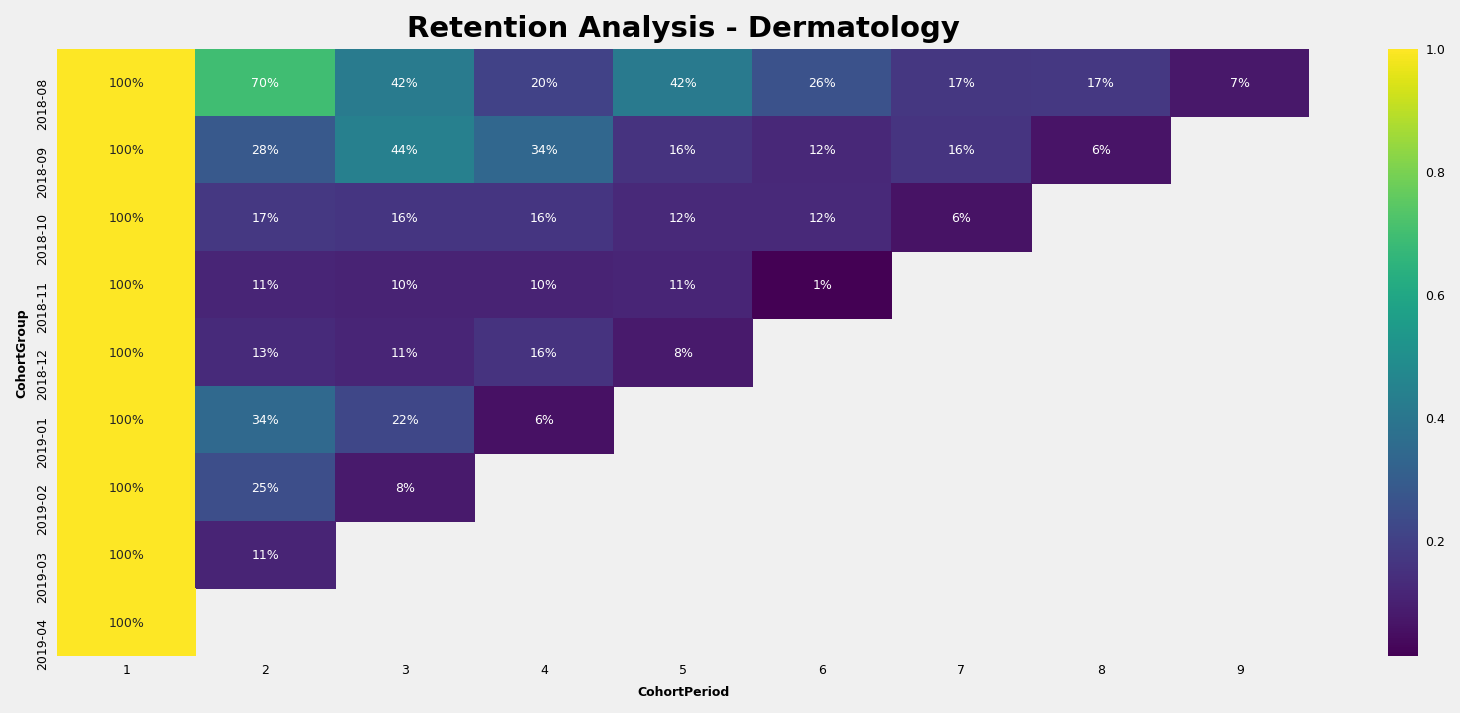

<Figure size 1800x750 with 0 Axes>

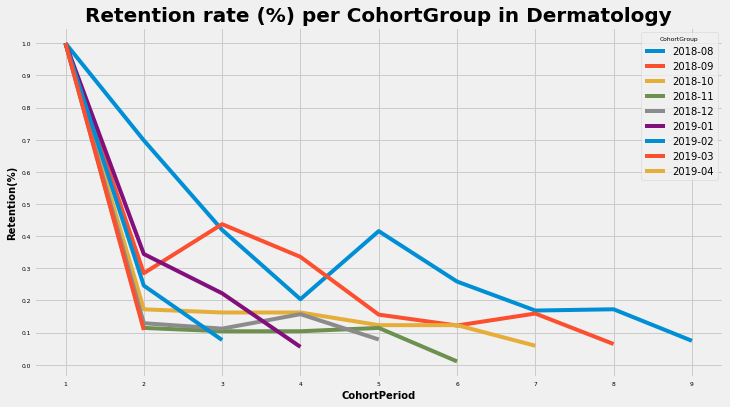

In [119]:
finalize(df, 'Dermatology')